In [1]:
# 1
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
# 2
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=55

In [3]:
# 3 
dataset=tf.keras.preprocessing.image_dataset_from_directory("\\Users\\RAVJOT SINGH RAYAT\\Desktop\\5th sem\\5th project\\cotton"
                                                           ,seed=123,shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                            batch_size=BATCH_SIZE
                                                           )

Found 1527 files belonging to 4 classes.


In [5]:
# 4
class_names = dataset.class_names
class_names

['bacterial_blight', 'curl_virus', 'fussarium_wilt', 'healthy']

In [6]:
# 5
len(dataset)

48

In [7]:
# 6
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 3 2 0 1 2 2 3 2 3 2 1 2 0 0 3 0 2 2 3 0 0 1 2 2 1 2 1 2 2 2 0]


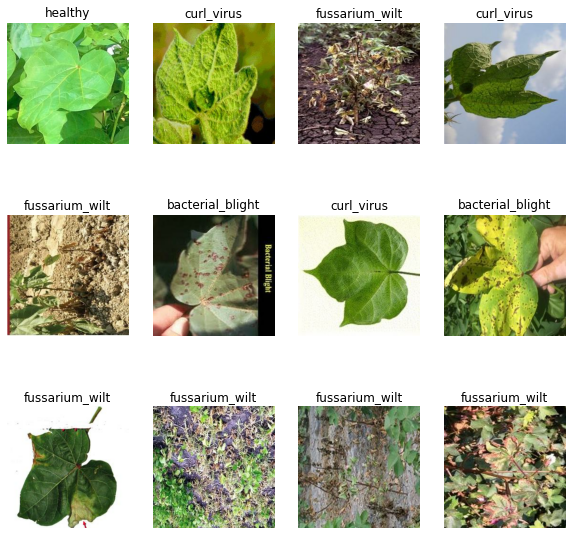

In [8]:
# 7   
# Visualizing
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
#     print(image_batch.shape)
#     print(label_batch.numpy())


In [9]:
train_size = 0.8
len(dataset)*train_size

38.400000000000006

In [10]:
train_ds = dataset.take(38)
len(train_ds)

38

In [11]:
test_ds = dataset.skip(38)
len(test_ds)

10

In [12]:
val_size=0.1
len(dataset)*val_size

4.800000000000001

In [13]:
val_ds = test_ds.take(5)
len(val_ds)

5

In [14]:
test_ds = test_ds.skip(5)
len(test_ds)

5

In [15]:
# 8
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
# 9 
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

38

In [18]:
len(val_ds)

4

In [19]:
len(test_ds)

6

In [20]:
# 10    
# Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle( 1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
# 11
# Scale
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [22]:
# 12
data_augmentation = tf.keras.Sequential([
 layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),   
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [23]:
# Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
# 13
# Neural Network
# CHANNELS=3
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [27]:
model.summary ()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [28]:
# 14
# Compiling the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [29]:
# 15
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=55,
)

Epoch 1/55
38/38 [==============================] - 402s 10s/step - loss: 1.3737 - accuracy: 0.3041 - val_loss: 1.1978 - val_accuracy: 0.5882
Epoch 2/55
38/38 [==============================] - 357s 9s/step - loss: 1.0230 - accuracy: 0.5692 - val_loss: 0.8821 - val_accuracy: 0.6555
Epoch 3/55
38/38 [==============================] - 297s 8s/step - loss: 0.7728 - accuracy: 0.7034 - val_loss: 0.8273 - val_accuracy: 0.7143
Epoch 4/55
38/38 [==============================] - 362s 10s/step - loss: 0.7258 - accuracy: 0.7258 - val_loss: 0.6804 - val_accuracy: 0.8067
Epoch 5/55
38/38 [==============================] - 359s 9s/step - loss: 0.6921 - accuracy: 0.7564 - val_loss: 0.8891 - val_accuracy: 0.7143
Epoch 6/55
38/38 [==============================] - 357s 9s/step - loss: 0.6217 - accuracy: 0.7722 - val_loss: 0.7199 - val_accuracy: 0.7899
Epoch 7/55
38/38 [==============================] - 352s 9s/step - loss: 0.5504 - accuracy: 0.8028 - val_loss: 0.5640 - val_accuracy: 0.8235
Epoch 8/55


In [30]:
# 16
scores=model.evaluate(test_ds)

6/6 [==============================] - 14s 2s/step - loss: 0.2307 - accuracy: 0.9479


In [31]:
scores

[0.23070162534713745, 0.9479166865348816]

In [32]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 55, 'steps': 38}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

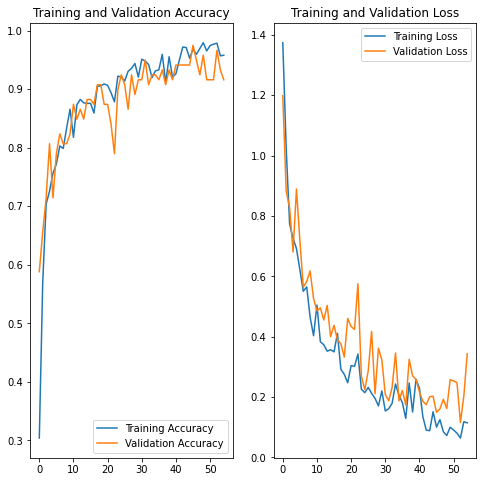

In [51]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(55), acc, label='Training Accuracy')
plt.plot(range(55), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(55), loss, label='Training Loss')
plt.plot(range(55), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: healthy
1/1 [==============================] - 2s 2s/step
predicted label: healthy


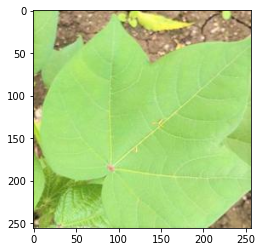

In [52]:
# 17
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [53]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 95ms/step


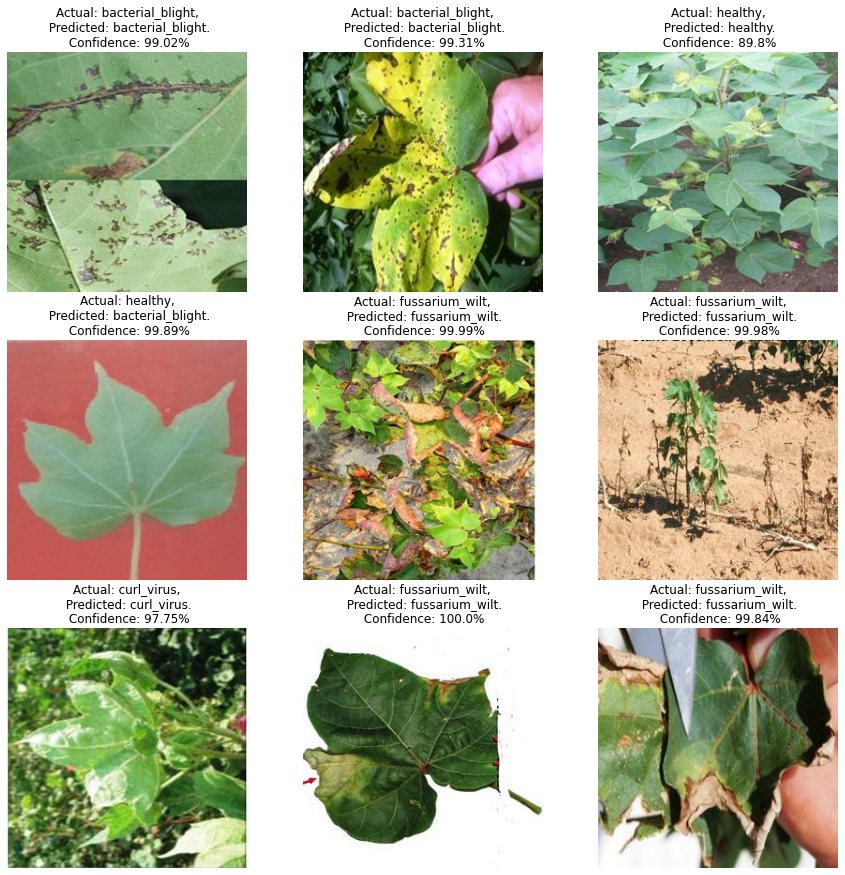

In [54]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [48]:
import os
model_version= 3 #max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/3\assets


INFO:tensorflow:Assets written to: ../saved_models/3\assets


In [49]:
os.listdir("../saved_models")


['.idea', '.ipynb_checkpoints', '1', '2', '3']